In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import h5py
import multigrate
from mofapy2.run.entry_point import entry_point

In [3]:
%config InlineBackend.figure_format = 'retina'

# MOFA 2

## Load the datasets

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [19]:
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [20]:
ent.set_data_options(
    scale_groups = False, 
    scale_views = False
)

In [21]:
ent.set_data_matrix([[scrna.X.A], [scatac.X.A]], views_names=['scRNA', 'scATAC'])

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='scRNA' group='group0' with N=10000 samples and D=3999 features...
Successfully loaded view='scATAC' group='group0' with N=10000 samples and D=40018 features...





In [22]:
ent.set_model_options(
    factors = 20, 
    spikeslab_weights = True, 
    ard_factors = True,
    ard_weights = True
)

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (scRNA): gaussian
- View 1 (scATAC): gaussian




In [23]:
ent.set_train_options(
    iter = 1000, 
    convergence_mode = "fast", 
    startELBO = 1, 
    freqELBO = 1, 
    dropR2 = 0.001, 
    gpu_mode = False, 
    verbose = False, 
    seed = 1
)

In [24]:
ent.build()

In [25]:
ent.run()



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -5708159641.04 

Iteration 1: time=468.03, ELBO=-49665105.24, deltaELBO=5658494535.800 (99.12992789%), Factors=19
Iteration 2: time=345.92, ELBO=-44386378.19, deltaELBO=5278727.049 (0.09247686%), Factors=18
Iteration 3: time=316.10, ELBO=-43619864.51, deltaELBO=766513.676 (0.01342839%), Factors=17
Iteration 4: time=298.97, ELBO=-43259790.55, deltaELBO=360073.960 (0.00630806%), Factors=16
Iteration 5: time=267.18, ELBO=-42996944.28, deltaELBO=262846.269 (0.00460475%), Factors=15
Iteration 6: time=236.65, ELBO=-42809011.86, deltaELBO=187932.420 (0.00329235%), Factors=14
Iteration 7: time=232.69, ELBO=-42690500.91, deltaELBO=118510.951 (0.00207617%), Factors=13
Iteration 8: time=206.75, ELBO=-42597056.88, deltaELBO=93444.029 (0.00163703%), Factors=12
Iteration 9: time=209.65, ELBO=-42558998.39, deltaELBO=38058.492 (0.00066674%), Factors=12
Iteration 

In [26]:
outfile = '10xpbmc10k-mofa2.hdf5'
ent.save(outfile)

Saving model in 10xpbmc10k-mofa2.hdf5...


In [27]:
f = h5py.File(outfile)

In [28]:
z = np.concatenate([v[:,:] for k, v in f['expectations']['Z'].items()], axis=1).T

In [29]:
z.shape

(10000, 12)

In [30]:
# zs = np.concatenate([v[:] for k, v in f["samples"].items()], axis=0).astype(str)
# z = pd.DataFrame(z, index=zs).loc[adata.obs_names.values].to_numpy()

In [31]:
# adata.obsm['X_mofa'] = z
# w = np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T
# adata.varm['LFs'] = w

NameError: name 'adata' is not defined

In [32]:
# np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T.shape

(44017, 12)

In [62]:
# f.keys()

<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'imputed_data', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

In [66]:
# [v for k, v in f['expectations']['W'].items()]

[<HDF5 dataset "scATAC": shape (7, 40018), type "<f8">,
 <HDF5 dataset "scRNA": shape (7, 3999), type "<f8">]

In [33]:
z = sc.AnnData(z)
z.obs['cell_type'] = scrna.obs['cell_type'].tolist()

In [34]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'cell_type' as categorical


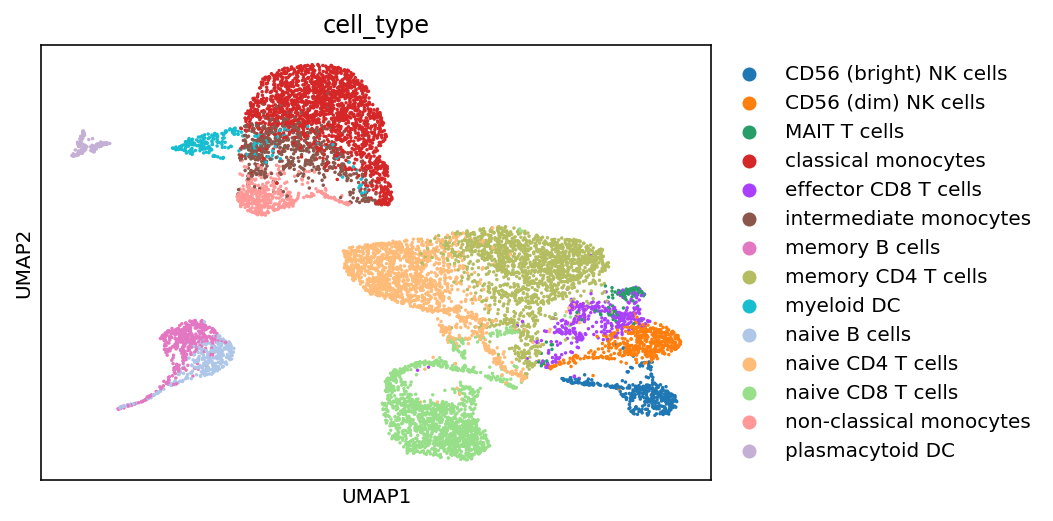

In [35]:
sc.pl.umap(z, color=['cell_type'], ncols=1)

In [44]:
sc.pp.pca(z)
multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    asw_batch=False,
    pcr_batch=False,
    graph_connectivity_batch=False,
    asw_label=True,
    nmi_=True,
    ari_=True,
    isolated_label_asw=False,
    method='MOFA'
)

Clustering...
ASW label...
NMI cluster/label...
ARI cluster/label...


,score
ASW_label,0.616420
NMI_cluster/label,0.760884
ARI_cluster/label,0.671333
